# Volume 3: Linear Regression
    Daniel Perkins
    MATH 403
    10/29/24

In [1]:
import numpy as np
import pandas as pd
import time
import statsmodels.api as sm
from sklearn import linear_model
from itertools import combinations
from matplotlib import pyplot as plt

## Problem 1
Write a function that takes as input $X$ and **y** as defined on page 1. Call this function **ols**. This function should return the least squares estimator for $\beta$ as a numpy array.

In [41]:
def ols(X, y):
    """
    Solves for the least squares estimator.
    Add a column of 1s to X.
    Parameters:
        X: n x d numpyarray
        y: n x 1 numpyarray
    Returns:
        beta: d x 1 numpyarray
    """
    # If we only get 1-D input, make it 2D
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    if X.ndim == 1:
        X = X.reshape(-1, 1)   
    X = np.hstack((np.ones((len(X), 1)), X))  # Add column of ones
    Beta = np.linalg.solve(X.T@X, X.T@y)      # Equation 12.1
    return Beta

## Problem 2
Find the least squares estimator for $\beta$ using this random data. 
Produce a plot showing the random data and the line of best fit determined by the least squares estimator for $\beta$. 
Your plot should include a title, axis labels, and a legend. 

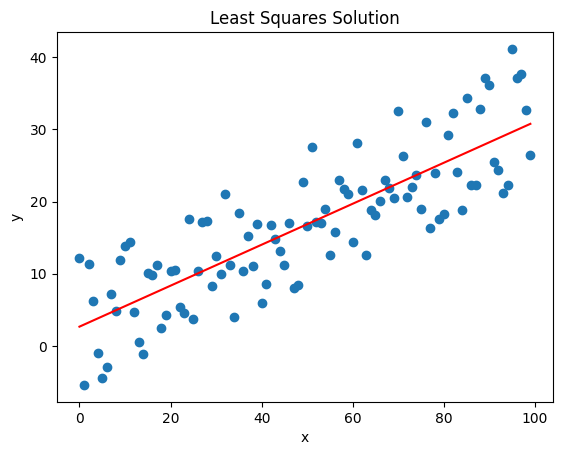

In [54]:
n = 100 # Number of points to generate
X = np.arange(100) # The input X for the function ols
eps = np.random.uniform(-10, 10, size=(100,)) # Noise to generate random y←-coordinates
y = .3*X + 3 + eps # The input y for the function ols
# Reshape input and output to make it 2-D 
y = y.reshape(-1, 1)
X = X.reshape(-1, 1)

# Find least squares solution
beta = ols(X, y)

plt.title("Least Squares Solution")
plt.scatter(X, y, label="Data")
plt.plot(X, beta[0] + X@beta[1:], color="red", label="Least Squares")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Problem 3
Write a function that finds the least squares estimator for rank-deficient models using the SVD. 
The function should still take $X$ and **y** as inputs. Call the function **svd_ols** and return the least squares estimator for $\beta$ as a numpy array.

In [ ]:
def svd_ols(X, y):
    """
    Solves for the least squares estimator using the SVD.
    Add a column of 1s to X.
    Parameters:
        X: n x d numpyarray
        y: n x 1 numpyarray
    Returns:
        beta: d x 1 numpy array
    """
    raise Exception("Problem 3 Incomplete")

## Problem 4
Use your function **svd_ols** to find the least squares estimator for a cubic polynomial. 
Create a plot that shows a scatter plot of the data and a curve using the least squares estimator. 
Your plot should include a title, axis labels, and a legend.

## Problem 5
The file **realestate.csv** contains transaction data from 2012-2013. 
It has columns for transaction data, house age, distance to nearest MRT station, number of convenience stores, latitude, longitude, and house price of unit area.
Each row in the array is a separate measurement.

Find the combination of variables that builds the model with the best $R^2$ value when predicting **house price of unit area**. Use statsmodels to build each model and calculate $R^2$. Use **statsmodels** to build each model and calculate $R^2$. Using the same combination of variables, time the methods **ols**, **svd_ols**, and **statsmodels** . Return a list with the first element being a tuple of times for each method and the second element being the best $R^2$ value from the first part of the problem.

In [ ]:
def problem5():
    """
    Find the best R2 value using statsmodels.
    Then time ols, svd_ols, and statsmodlels.
    Returns:
        list(): a tuple of times and the best R2 value
    """
    raise Exception("Problem 5 Incomplete")

## Problem 6
Use the file **realestate.csv** and the Python Example on page 4 as a template for constructing **y** and $X$ and calculating model AIC and BIC. 
For the dependent variable, use **house price of unit area**. 
For the independent variables, use **house age**, use **distance to the nearest MRT station**, **number of convenience stores**, **latitude**, and **longitude**.

Find the model that has the lowest AIC and the model that has the lowest BIC. Print the features of the model with the lowest AIC and then the features of the model with the lowest BIC as separate lists.

## Problem 7
Use Ridge and Lasso Regression to model **house price of unit area** from the file **realestate.csv**.
Before fitting each model, run a GridSearch on $\alpha$ to find the optimal value.
Then use the optimal $\alpha$ to fit the model.
Once you have fit the model, you can use the **score** method to get $R^2$. 
Print $R^2$ for each model as a tuple. 